# Data Science project. See the report.pdf to see the main results grabbed from this notebook.

This notebook shows different tools used in data science to the study of data of transactions made by customers during 2 years.

Such tools include direct analysis of the data accompanied with some visualization. Classical methods used as multi-class classifiers and deep neural networks. Also, we build an ARIMA model for a quantity of interest regarding time series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns
%matplotlib inline


trans_short contains personal information of customers such as the age group it belong to, the minimum income, etc, the products the customers bought and the department such product belongs to and the day and week of the transaction and some other details about the discounts

In [170]:
prod = pd.read_csv('product.csv')
trans = pd.read_csv('transaction_data.csv')
dem = pd.read_csv('demographic.csv')

# We are going to work with the following data that include the previous three after pre-processing them:
trans_short=pd.read_csv('mix_values.csv',usecols=range(1,14))

In [224]:
trans_short.head(5)

,household_key,DAY,WEEK_NO,PRODUCT_ID,STORE_ID,SALES_VALUE,PAID_BY_CUSTOMER,DEPARTMENT,AGE,HH_COMP_NUMBER,RETAIL_DISC,MIN_INCOME,QUANTITY
0,2375,1,1,1004906,364,1.39,1.99,PRODUCE,0,0,-0.60,0,1
1,2375,1,1,1033142,364,0.82,0.82,PRODUCE,0,0,0.00,0,1
2,2375,1,1,1036325,364,0.99,1.29,PRODUCE,0,0,-0.30,0,1
3,2375,1,1,1082185,364,1.21,1.21,PRODUCE,0,0,0.00,0,1
4,2375,1,1,8160430,364,1.50,1.89,PRODUCE,0,0,-0.39,0,1


In [7]:
trans_short['DEPARTMENT'].unique()

array(['PRODUCE', 'GROCERY', 'DRUG GM', 'MEAT', 'MEAT-PCKGD', 'DELI',
       'SEAFOOD-PCKGD', ' ', 'PASTRY', 'NUTRITION', 'VIDEO RENTAL',
       'MISC SALES TRAN', 'FLORAL', 'SEAFOOD', 'SALAD BAR', 'AUTOMOTIVE',
       'SPIRITS', 'COSMETICS', 'MISC. TRANS.', 'GARDEN CENTER',
       'CHEF SHOPPE', 'TRAVEL & LEISUR', 'COUP/STR & MFG', 'KIOSK-GAS',
       'FROZEN GROCERY', 'RESTAURANT', 'HOUSEWARES', 'PORK',
       'POSTAL CENTER', 'GM MERCH EXP', 'CNTRL/STORE SUP',
       'PROD-WHS SALES', 'DAIRY DELI', 'HBC', 'CHARITABLE CONT', 'RX',
       'TOYS', 'PHOTO', 'DELI/SNACK BAR', 'GRO BAKERY', 'PHARMACY SUPPLY',
       'ELECT &PLUMBING', 'MEAT-WHSE', 'VIDEO'], dtype=object)

In [171]:
trans_short.columns

Index(['household_key', 'DAY', 'WEEK_NO', 'PRODUCT_ID', 'STORE_ID',
       'SALES_VALUE', 'PAID_BY_CUSTOMER', 'DEPARTMENT', 'AGE',
       'HH_COMP_NUMBER', 'RETAIL_DISC', 'MIN_INCOME', 'QUANTITY'],
      dtype='object')

In [225]:
trans_short.set_index(['STORE_ID','WEEK_NO','PRODUCT_ID'],inplace=False)
trans_store_week=trans_short.groupby(['STORE_ID','WEEK_NO','PRODUCT_ID']).sum().reset_index()[['STORE_ID','WEEK_NO','PRODUCT_ID','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]
trans_store_week.head(5)

,STORE_ID,WEEK_NO,PRODUCT_ID,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1,5,480014,15.00,15.72,-0.72
1,1,5,718226,7.40,7.40,0.00
2,1,6,480014,5.00,5.24,-0.24
3,1,14,6903760,2.49,2.49,0.00
4,2,41,702733,4.29,4.29,0.00


In [226]:
trans_store_week[trans_store_week['WEEK_NO']==50].head(5)

,STORE_ID,WEEK_NO,PRODUCT_ID,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
1472,136,50,594426,2.49,2.49,0.00
2497,189,50,439933,4.29,4.29,0.00
2498,189,50,442456,5.00,6.98,-1.98
2499,189,50,445172,42.76,42.76,0.00
2500,189,50,480433,5.99,9.99,-4.00


In [ ]:
trans_day=trans_short.groupby(['household_key','DAY']).mean().reset_index()[['household_key', 'DAY', 'SALES_VALUE', 'PAID_BY_CUSTOMER', 'RETAIL_DISC', 'QUANTITY','AGE']]
trans_day.head(5)

In [227]:
trans_50=trans_week[trans_week['WEEK_NO']==50]
trans_50.head(5)

,WEEK_NO,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
49,50,3.06,3.59,-0.53


In [228]:
trans_50[trans_50['SALES_VALUE']==trans_50['SALES_VALUE'].max()]

,WEEK_NO,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
49,50,3.06,3.59,-0.53


Later on, we are going to plot a heat map of the money spent by customers classified by group age, for instance. Also, I program a multi-class classifier to predict to what group age the customers whose age we ignore belong to.

In [28]:
hh_code={1:1, -1:2, 2:3, -2:4, 3:5, 0:0}
age_code={65:6,45:4, 25:2, 35:3, 19:1, 55:5, 0:0}

In [229]:
trans_short['HH_COMP_NUMBER_CODE']=trans_short['HH_COMP_NUMBER'].map(hh_code)
trans_short['AGE_CODE']=trans_short['AGE'].map(age_code)

In [230]:
trans_short.set_index(['household_key'],inplace=False)
trans_hh=trans_short.groupby(['household_key','DEPARTMENT']).mean().reset_index()
trans_hh_pivot=trans_hh.pivot_table(index='household_key',values='PAID_BY_CUSTOMER',columns='DEPARTMENT')
trans_hh_pivot=trans_hh_pivot.join(trans_hh['HH_COMP_NUMBER'])

trans_short.set_index(['household_key'],inplace=False)
trans_age=trans_short.groupby(['household_key','DEPARTMENT']).mean().reset_index()
trans_age_pivot=trans_age.pivot_table(index='household_key',values='PAID_BY_CUSTOMER',columns='DEPARTMENT')
trans_age_pivot=trans_age_pivot.join(trans_age['AGE'])

In [231]:
trans_hh_pivot.drop(' ',axis=1,inplace=True)
trans_age_pivot.drop(' ',axis=1,inplace=True)

In [232]:
trans_hh_pivot.fillna(value=-1,inplace=True)
trans_age_pivot.fillna(value=-1,inplace=True)

In [233]:
trans_age_pivot.columns

Index(['AUTOMOTIVE', 'CHARITABLE CONT', 'CHEF SHOPPE', 'CNTRL/STORE SUP',
       'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR',
       'DRUG GM', 'ELECT &PLUMBING', 'FLORAL', 'FROZEN GROCERY',
       'GARDEN CENTER', 'GM MERCH EXP', 'GRO BAKERY', 'GROCERY', 'HBC',
       'HOUSEWARES', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE',
       'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION', 'PASTRY',
       'PHARMACY SUPPLY', 'PHOTO', 'PORK', 'POSTAL CENTER', 'PROD-WHS SALES',
       'PRODUCE', 'RESTAURANT', 'RX', 'SALAD BAR', 'SEAFOOD', 'SEAFOOD-PCKGD',
       'SPIRITS', 'TOYS', 'TRAVEL & LEISUR', 'VIDEO', 'VIDEO RENTAL', 'AGE'],
      dtype='object')

In [35]:
#from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

#for i in trans_age_pivot.columns[:-1]:
#    scaler=StandardScaler()
#    scaler.fit(trans_age_pivot[i].values,y=None)
#    trans_age_pivot[i]=scaler.transform(trans_age_pivot[i].values,y=None)

In [36]:
trans_age_pivot['AGE'].unique()

array([ 6.,  0.,  4.,  2.,  3.,  1.,  5.])

In [37]:
trans_age_pivot.head(5)

,AUTOMOTIVE,CHARITABLE CONT,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DAIRY DELI,DELI,DELI/SNACK BAR,DRUG GM,...,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TOYS,TRAVEL & LEISUR,VIDEO,VIDEO RENTAL,AGE
household_key,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.0,3.293115,-1.0,3.329205,...,-1.0,4.46625,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
2,-1.0,-1.0,-1.0,-1.0,5.578,-1.0,-1.0,3.688462,-1.0,3.554536,...,-1.0,-1.00000,-1.0,8.990000,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
3,-1.0,-1.0,-1.0,-1.0,1.250,-1.0,-1.0,7.456000,-1.0,2.247500,...,-1.0,1.36000,-1.0,5.990000,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
4,-1.0,-1.0,-1.0,-1.0,1.490,-1.0,-1.0,7.175000,-1.0,11.072333,...,-1.0,-1.00000,-1.0,4.756667,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
5,-1.0,-1.0,-1.0,-1.0,4.740,-1.0,-1.0,4.141429,-1.0,4.352745,...,-1.0,-1.00000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,6.0


# We prepare the data to build different multi-class classifiers to predict the age and the household type of the customers we ignore this information.

## The customers whose this information is ignored have a value==0 in 'HH_COMP_NUMBER' and 'AGE' columns

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X = trans_hh_pivot[trans_hh_pivot['HH_COMP_NUMBER']!=0][['AUTOMOTIVE', 'CHARITABLE CONT', 'CHEF SHOPPE', 'CNTRL/STORE SUP',
       'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR',
       'DRUG GM', 'ELECT &PLUMBING', 'FLORAL', 'FROZEN GROCERY',
       'GARDEN CENTER', 'GM MERCH EXP', 'GRO BAKERY', 'GROCERY', 'HBC',
       'HOUSEWARES', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE',
       'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION', 'PASTRY',
       'PHARMACY SUPPLY', 'PHOTO', 'PORK', 'POSTAL CENTER', 'PROD-WHS SALES',
       'PRODUCE', 'RESTAURANT', 'RX', 'SALAD BAR', 'SEAFOOD', 'SEAFOOD-PCKGD',
       'SPIRITS', 'TOYS', 'TRAVEL & LEISUR', 'VIDEO', 'VIDEO RENTAL']].as_matrix()

Xa = trans_age_pivot[trans_age_pivot['AGE']!=0][['AUTOMOTIVE', 'CHARITABLE CONT', 'CHEF SHOPPE', 'CNTRL/STORE SUP',
       'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR',
       'DRUG GM', 'ELECT &PLUMBING', 'FLORAL', 'FROZEN GROCERY',
       'GARDEN CENTER', 'GM MERCH EXP', 'GRO BAKERY', 'GROCERY', 'HBC',
       'HOUSEWARES', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE',
       'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION', 'PASTRY',
       'PHARMACY SUPPLY', 'PHOTO', 'PORK', 'POSTAL CENTER', 'PROD-WHS SALES',
       'PRODUCE', 'RESTAURANT', 'RX', 'SALAD BAR', 'SEAFOOD', 'SEAFOOD-PCKGD',
       'SPIRITS', 'TOYS', 'TRAVEL & LEISUR', 'VIDEO', 'VIDEO RENTAL']].as_matrix()

X_topred = trans_hh_pivot[trans_hh_pivot['HH_COMP_NUMBER']==0][['AUTOMOTIVE',  'CHARITABLE CONT', 'CHEF SHOPPE', 'CNTRL/STORE SUP',
       'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR',
       'DRUG GM', 'FLORAL', 'FROZEN GROCERY',
       'GARDEN CENTER', 'GROCERY', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD', 
       'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION', 'PASTRY',
        'PHOTO', 'PRODUCE', 'RESTAURANT', 'SALAD BAR', 'SEAFOOD', 'SEAFOOD-PCKGD',
       'SPIRITS', 'TRAVEL & LEISUR']].as_matrix()

Xa_topred = trans_age_pivot[trans_age_pivot['AGE']==0][['AUTOMOTIVE',  'CHARITABLE CONT', 'CHEF SHOPPE', 'CNTRL/STORE SUP',
       'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR',
       'DRUG GM', 'FLORAL', 'FROZEN GROCERY',
       'GARDEN CENTER', 'GROCERY', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD', 
       'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION', 'PASTRY',
        'PHOTO', 'PRODUCE', 'RESTAURANT', 'SALAD BAR', 'SEAFOOD', 'SEAFOOD-PCKGD',
       'SPIRITS', 'TRAVEL & LEISUR']].as_matrix()

y_bef = trans_hh_pivot[trans_hh_pivot['HH_COMP_NUMBER']!=0]['HH_COMP_NUMBER'].as_matrix()-1
y =keras.utils.to_categorical(y_bef,num_classes=5)

ya_bef = trans_age_pivot[trans_age_pivot['AGE']!=0]['AGE'].as_matrix()-1
ya =keras.utils.to_categorical(ya_bef,num_classes=6)

X_trainbef, X_testbef, y_trainbef, y_testbef = train_test_split(X, y_bef, test_size = 0.1, random_state = 0)
Xa_trainbef, Xa_testbef, ya_trainbef, ya_testbef = train_test_split(Xa, ya_bef, test_size = 0.1, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 31)
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, ya, test_size = 0.2, random_state = 31)


Using TensorFlow backend.


In [39]:
features=len(['AUTOMOTIVE', 'CHARITABLE CONT', 'CHEF SHOPPE', 'CNTRL/STORE SUP',
       'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR',
       'DRUG GM', 'ELECT &PLUMBING', 'FLORAL', 'FROZEN GROCERY',
       'GARDEN CENTER', 'GM MERCH EXP', 'GRO BAKERY', 'GROCERY', 'HBC',
       'HOUSEWARES', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE',
       'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION', 'PASTRY',
       'PHARMACY SUPPLY', 'PHOTO', 'PORK', 'POSTAL CENTER', 'PROD-WHS SALES',
       'PRODUCE', 'RESTAURANT', 'RX', 'SALAD BAR', 'SEAFOOD', 'SEAFOOD-PCKGD',
       'SPIRITS', 'TOYS', 'TRAVEL & LEISUR', 'VIDEO', 'VIDEO RENTAL'])

# The samples use for the training are not equally represented in all the groups as I show in the following histograms

Histogram of Ages

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f869dacef60>]], dtype=object)

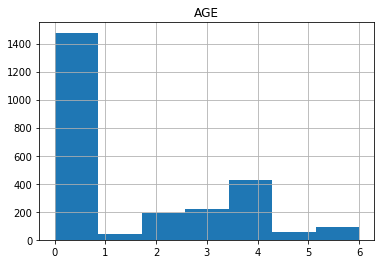

In [40]:
trans_age_pivot.hist(column='AGE',bins=7)

Histogram of household composition

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f869da85518>]], dtype=object)

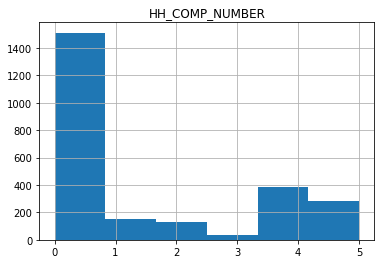

In [41]:
trans_hh_pivot.hist(column='HH_COMP_NUMBER',bins=6)

In [1319]:
y_test.shape

(198, 5)

In [42]:
len(y_testbef==3)

99

## Random forest Classifier.

I include for each model the confusion matrix, and a classification report with the main statistics

[[ 0  0  0 11  3]
 [ 1  0  0  5  4]
 [ 0  0  0  1  0]
 [ 0  1  0 30  4]
 [ 2  1  0 29  7]]
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        14
        1.0       0.00      0.00      0.00        10
        2.0       0.00      0.00      0.00         1
        3.0       0.39      0.86      0.54        35
        4.0       0.39      0.18      0.25        39

avg / total       0.29      0.37      0.29        99



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/leos/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


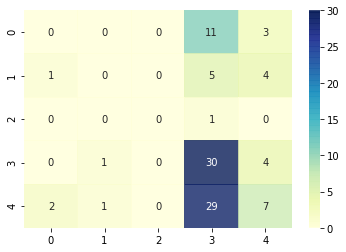

In [44]:
# training a DescisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

dtree_model = RandomForestClassifier(n_estimators=40, criterion='entropy',verbose=True).fit(X_trainbef, y_trainbef)
dtree_predictions = dtree_model.predict(X_testbef)
# creating a confusion matrix
cm = confusion_matrix(y_testbef, dtree_predictions)
print(cm)
print(classification_report(y_testbef,dtree_predictions))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

### Support Vector Machine classifier

In [46]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
 
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1,degree=10, decision_function_shape='ovo').fit(X_trainbef, y_trainbef)
svm_predictions = svm_model_linear.predict(X_testbef)
print(classification_report(y_test,svm_predictions))
# model accuracy for X_test  
accuracy = svm_model_linear.score(X_testbef, y_testbef)
print(accuracy)
# creating a confusion matrix
cm = confusion_matrix(y_testbef, svm_predictions)
print(cm)

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        14
        1.0       0.00      0.00      0.00        10
        2.0       0.00      0.00      0.00         1
        3.0       0.35      1.00      0.52        35
        4.0       0.00      0.00      0.00        39

avg / total       0.12      0.35      0.18        99

0.353535353535
[[ 0  0  0 14  0]
 [ 0  0  0 10  0]
 [ 0  0  0  1  0]
 [ 0  0  0 35  0]
 [ 0  0  0 39  0]]


/home/leos/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## K-Nearest Neighbours classifier

0.349514563107
[[ 0  0  0  7  0  0]
 [ 0  3  1 19  0  0]
 [ 0  1  2 21  0  0]
 [ 0  1  3 31  0  0]
 [ 0  0  0  3  0  0]
 [ 0  1  1  9  0  0]]
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         7
        1.0       0.50      0.13      0.21        23
        2.0       0.29      0.08      0.13        24
        3.0       0.34      0.89      0.50        35
        4.0       0.00      0.00      0.00         3
        5.0       0.00      0.00      0.00        11

avg / total       0.30      0.35      0.24       103



/home/leos/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


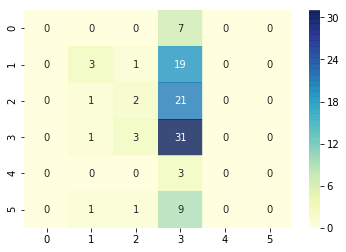

In [48]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 30).fit(Xa_trainbef, ya_trainbef)
 
# accuracy on X_test
accuracy = knn.score(Xa_testbef, ya_testbef)
print(accuracy)
 
# creating a confusion matrix
knn_predictions = knn.predict(Xa_testbef) 
cm = confusion_matrix(ya_testbef, knn_predictions)
print(cm)
print(classification_report(ya_testbef,knn_predictions))
sns.heatmap(pd.DataFrame(cm), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

## Now, we build Deep neural networks using a Keras multi-class classifiers:

In [260]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline



### We build a deep neural network with two hideen layers, one with 10 neurons ans other with 5

In [263]:
model = Sequential()
# Dense(12) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(10, activation='relu', input_dim=features))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

sgd = SGD(lr=0.02, decay=1e-6, momentum=0.5, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,epochs=200,batch_size=128,verbose=0)
score = model.evaluate(X_test, y_test, batch_size=128,verbose=0)


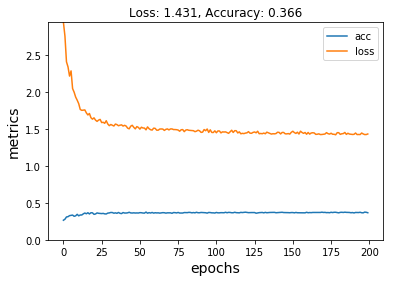

In [264]:
plot_loss_accuracy(history)
plt.xlabel('epochs',fontsize=14)
plt.ylabel('metrics',fontsize=14)
plt.savefig('metricsDNN.pdf')

In [265]:
### And a deep neural network with one hideen layer with 12 neurons

In [266]:
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(12, activation='relu', input_dim=features))
model.add(Dropout(0.5))
#model.add(Dense(6, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(6, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

sgd = SGD(lr=0.25, decay=1e-6, momentum=0.5, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(Xa_train, ya_train,epochs=200,batch_size=512,verbose=0)
score = model.evaluate(Xa_test, ya_test, batch_size=512,verbose=0)


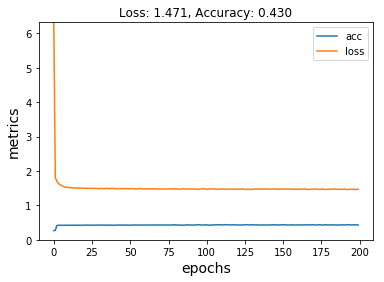

In [267]:
plot_loss_accuracy(history)
plt.xlabel('epochs',fontsize=14)
plt.ylabel('metrics',fontsize=14)
plt.savefig('metricsDNN.pdf')

# Conclusion:

The accuracy of this model is higher and contains less neurons so overfitting is likely to be present

### We go back to the data analysis, we want to extract extremal values to better understand the data:

In [74]:
# trans_short.set_index(['AGE','DEPARTMENT'],inplace=False)
trans_age_depto=trans_short.groupby(['AGE','DEPARTMENT']).sum().reset_index()[['AGE','DEPARTMENT','QUANTITY','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]

In [75]:
trans_short.set_index(['HH_COMP_NUMBER','DEPARTMENT'],inplace=False)
trans_hh_depto=trans_short.groupby(['HH_COMP_NUMBER','DEPARTMENT']).sum().reset_index()[['HH_COMP_NUMBER','DEPARTMENT','QUANTITY','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]

In [76]:
trans_age_depto.head()

,AGE,DEPARTMENT,QUANTITY,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1.00,,0,0.00,0.00,0.00
1,1.00,AUTOMOTIVE,2,11.64,11.64,0.00
2,1.00,CHEF SHOPPE,28,77.31,77.31,0.00
3,1.00,CNTRL/STORE SUP,2,2.00,2.00,0.00
4,1.00,COSMETICS,189,778.31,881.32,-103.01


In [66]:
trans_by_prod=trans_short.groupby('PRODUCT_ID',sort=True).sum().reset_index()

In [67]:
trans_short.set_index(['STORE_ID','WEEK_NO'],inplace=False)
trans_week=trans_short.groupby(['STORE_ID','WEEK_NO']).sum().reset_index()[['STORE_ID','WEEK_NO','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]

In [68]:
trans_week.head()

,STORE_ID,WEEK_NO,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1,5,22.40,23.12,-0.72
1,1,6,5.00,5.24,-0.24
2,1,14,2.49,2.49,0.00
3,2,41,4.29,4.29,0.00
4,2,93,13.99,13.99,0.00


In [70]:
print('The store that sells more is: ',trans_week[trans_week['SALES_VALUE']==trans_['SALES_VALUE'].max()]['STORE_ID'].iloc[0])

The store that sells more is:  367


In [71]:
print('The best sold product is ',trans_by_prod[trans_by_prod['QUANTITY']==trans_by_prod['QUANTITY'].max()]['PRODUCT_ID'].iloc[0])

The best sold product is  6534178


In [72]:
prod[prod['PRODUCT_ID']==trans_by_prod[trans_by_prod['QUANTITY']==trans_by_prod['QUANTITY'].max()]['PRODUCT_ID'].iloc[0]]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [73]:
print('The best sold product is ',trans_by_prod[trans_by_prod['SALES_VALUE']==trans_by_prod['SALES_VALUE'].max()]['PRODUCT_ID'].iloc[0])

The best sold product is  6534178


In [74]:
prod[prod['PRODUCT_ID']==trans_by_prod[trans_by_prod['SALES_VALUE']==trans_by_prod['SALES_VALUE'].max()]['PRODUCT_ID'].iloc[0]]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [75]:
trans_week=trans_short.groupby('WEEK_NO').sum().reset_index()[['WEEK_NO','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]

In [76]:
print('The best week for retailers was ',trans_week[trans_week['SALES_VALUE']==trans_week['SALES_VALUE'].max()]['WEEK_NO'].iloc[0])

The best week for retailers was  92


In [77]:
trans_short.set_index(['WEEK_NO','STORE_ID'],inplace=False)
trans_store_week=trans_short.groupby(['WEEK_NO','STORE_ID']).sum().reset_index()[['WEEK_NO','STORE_ID','QUANTITY','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]

In [82]:
trans_short.set_index(['household_key','DAY'],inplace=False)
trans_customer_day=trans_short.groupby(['household_key','DAY']).mean().reset_index()[['household_key', 'DAY','QUANTITY','SALES_VALUE','PAID_BY_CUSTOMER',
        'RETAIL_DISC']]

In [144]:
trans_short.set_index(['household_key','WEEK_NO'],inplace=False)
trans_customer_week=trans_short.groupby(['household_key','WEEK_NO']).mean().reset_index()[['household_key', 'WEEK_NO','QUANTITY','SALES_VALUE','PAID_BY_CUSTOMER',
        'RETAIL_DISC','MIN_INCOME']]

In [84]:
trans_customer_week.head()

,household_key,WEEK_NO,QUANTITY,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC,MIN_INCOME
0,1,8,1.13,2.62,3.17,-0.55,"35,000.00"
1,1,10,1.17,3.43,4.14,-0.72,"35,000.00"
2,1,13,1.08,2.24,2.80,-0.56,"35,000.00"
3,1,14,1.39,2.76,3.26,-0.48,"35,000.00"
4,1,15,1.18,3.14,4.11,-0.97,"35,000.00"


In [85]:
trans_customer_week['PAID_BY_CUSTOMER'].sort_values(ascending=False).head(5)

50512    299.99
102946   299.99
106679   264.48
37600    214.99
2961     200.40
Name: PAID_BY_CUSTOMER, dtype: float64

In [86]:
trans_customer_week[trans_customer_week.index==75592]

,household_key,WEEK_NO,QUANTITY,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC,MIN_INCOME
75592,1609,49,133.05,10.78,11.03,-0.24,"125,000.00"


In [89]:
trans_customer_day[trans_customer_day['PAID_BY_CUSTOMER']==trans_customer_day['PAID_BY_CUSTOMER'].max()]

,household_key,DAY,QUANTITY,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
92808,1064,437,1.00,299.99,299.99,0.00
187622,2191,401,1.00,299.99,299.99,0.00


In [90]:
trans_customer_day.head(5)

,household_key,DAY,QUANTITY,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1,51,1.13,2.62,3.17,-0.55
1,1,67,1.17,3.43,4.14,-0.72
2,1,88,1.08,2.24,2.80,-0.56
3,1,94,1.39,2.76,3.26,-0.48
4,1,101,1.18,3.14,4.11,-0.97


In [91]:
trans_week=trans_store_week.groupby('WEEK_NO').mean().reset_index()

In [92]:
trans_week.head()

,WEEK_NO,STORE_ID,QUANTITY,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1,"2,753.96",34.60,76.63,91.93,-15.25
1,2,"2,457.15",78.51,117.62,141.02,-23.34
2,3,"2,808.47",634.90,148.33,176.47,-28.00
3,4,"2,815.69",711.71,147.83,174.64,-26.70
4,5,"2,683.29",908.09,179.82,215.38,-35.38


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8657cbc3c8>]], dtype=object)

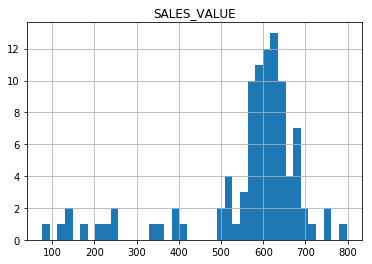

In [93]:
trans_week.hist(column='SALES_VALUE',bins=40)

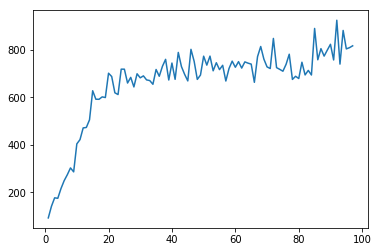

In [94]:
plt.plot(trans_week['WEEK_NO'],trans_week['PAID_BY_CUSTOMER'])

In [95]:
trans_week['SALES_VALUE'].mean()

564.14801346880188

## For some quantities we find either exponential or power-law behaviour. (See the report.pdf)

In [97]:
from scipy import stats

salesv_histo=np.histogram(trans_store_week['SALES_VALUE'],bins=100)
ysv=np.log(salesv_histo[0])
xsv=salesv_histo[1][:-1]

slopev, interceptv, r_valuev, p_valuev, std_errv = stats.linregress(xsv[40:90],ysv[40:90])
e=np.exp(interceptv)*np.exp(slopev*xsv)
line = slopev*xsv+interceptv

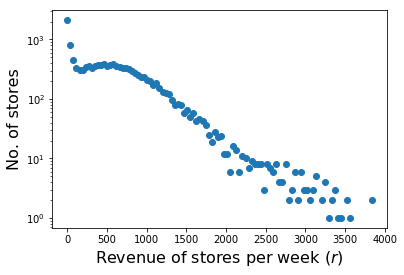

In [98]:
fig=plt.figure(figsize=(6,4))

#plt.xlim(0,3000)
#plt.ylim(1,10000)
plt.ylabel('No. of stores',fontsize=16)
plt.xlabel('Revenue of stores per week ($r$)',fontsize=16)
plt.yscale('log')
plt.plot(salesv_histo[1][:-1],salesv_histo[0],'o',salesv_histo[1][:-1],e, '-k',lw=3)
plt.savefig('histoSALES_STORE.pdf')

In [108]:
minAge={'65+':65,'45-54':45, '25-34':25, '35-44':35, '19-24':19, '55-64':55}
income={'35-49K':35000, '50-74K':50000, '25-34K':25000, '75-99K':75000, 'Under 15K':1, '100-124K':100000,
       '15-24K':15000, '125-149K':125000, '150-174K':150000, '250K+':250000, '175-199K':175000, '200-249K':200000}
maxincome={'35-49K':49000, '50-74K':74000, '25-34K':34000, '75-99K':99000, 'Under 15K':15000, '100-124K':124000,
       '15-24K':24000, '125-149K':149000, '150-174K':174000, '250K+':275000, '175-199K':199000, '200-249K':249000}

In [109]:
dem['MIN_INCOME']=dem['INCOME_DESC'].map(income)
dem['MAX_INCOME']=dem['INCOME_DESC'].map(maxincome)
dem['AGE']= dem['AGE_DESC'].map(minAge)

In [103]:
from scipy import stats

minincome_histo=np.histogram(dem['MIN_INCOME'],bins=6)
ys=np.log(minincome_histo[0])
xs=minincome_histo[1][:-1]

slope, intercept, r_value, p_value, std_err = stats.linregress(xs[2:60],ys[2:60])
e=np.exp(intercept)*np.exp(slope*xs)
line = slope*xs+intercept

# We make two pie charts to see the proportion of the customers belonging to an age group or to a group with a certain composition

In [104]:
fracs_income=[]
explode=[0,0,0,0,0.1,0,0,0,0,0,0,0]
colors=['aqua','gold', 'yellowgreen', 'orangered', 'lightskyblue','red','olive','orange','magenta','yellow','lime','khaki']
for i in [1,15000,25000,35000,50000,75000,100000,125000,150000,175000, 200000,250000]:
    fracs_income.append(dem[dem['MIN_INCOME']==i].count().ix[0]/dem.count().ix[0])

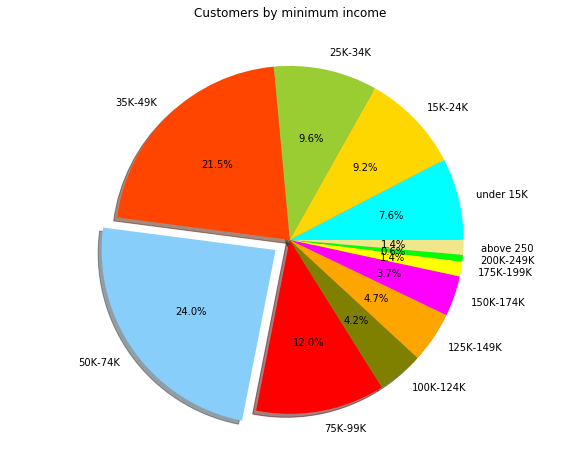

In [105]:
fig=plt.figure(figsize=(10,8))
plt.axis('equal')
plt.title('Customers by minimum income')
labels=['under 15K','15K-24K','25K-34K','35K-49K','50K-74K','75K-99K','100K-124K','125K-149K','150K-174K','175K-199K','200K-249K', 'above 250']
plt.pie(fracs_income, explode=explode,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.savefig('pie_income.pdf')

In [110]:
fracs_age=[]
explode=[0,0,0,0.1,0,0]
colors=['aqua','gold', 'yellowgreen', 'orangered', 'lightskyblue','red']
for i in [19,25,35,45,55,65]:
    fracs_age.append(dem[dem['AGE']==i].count().ix[0]/dem.count().ix[0])

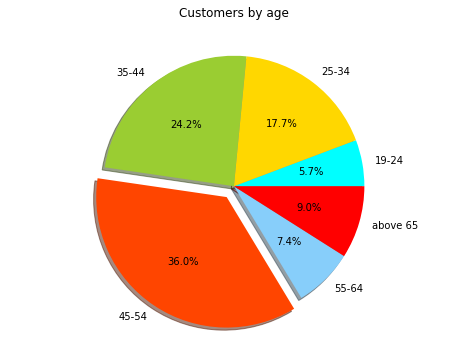

In [111]:
fig=plt.figure(figsize=(8,6))
plt.axis('equal')
plt.title('Customers by age')
labels=['19-24','25-34','35-44','45-54','55-64','above 65']
plt.pie(fracs_age, explode=explode,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.savefig('pie_age.pdf')

# Now we study two quantities that follow a particular law

## The money paid by customers per week follows an exponential law

In [122]:
from scipy import stats

paid_histo=np.histogram(trans_customer_week['PAID_BY_CUSTOMER'],bins=200)
ysp=np.log(paid_histo[0])
xsp=paid_histo[1][:-1]

slopep, interceptp, r_valuep, p_valuep, std_errp = stats.linregress(xsp[2:60],ysp[2:60])
e=np.exp(interceptp)*np.exp(slopep*xsp)
line = slopep*xs+interceptp

In [123]:
print(1/slopep)

-75.8127878686


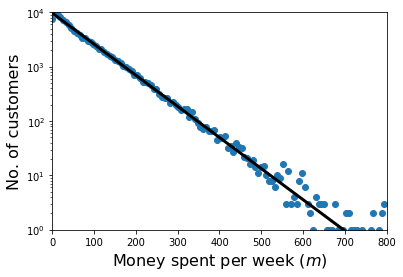

In [124]:
fig=plt.figure(figsize=(6,4))

plt.xlim(0,800)
plt.ylim(1,10000)
plt.ylabel('No. of customers',fontsize=16)
plt.xlabel('Money spent per week ($m$)',fontsize=16)
plt.yscale('log')
plt.plot(paid_histo[1][:-1],paid_histo[0],'o',paid_histo[1][:-1],e, '-k',lw=3)
plt.savefig('histoPAIDperWEEK.pdf')

In [115]:
trans_by_prod['SALES_VALUE'].max()

477754.4900000089

## The sales obtained by product during the whole period follows a power-law. This means that there are many products whose sales value is low

In [125]:
trans_store_week

from scipy import stats

sales_histo=np.histogram(trans_by_prod['SALES_VALUE'],bins=8000)
ys=np.log10(sales_histo[0])
xs=np.log10(sales_histo[1][1:-1])
print(ys[1:40])
pl=np.exp(intercept+slope*sales_histo[1][1:-1])

#slopea, intercepta, r_value, p_value, std_err = stats.linregress(xs[1:10],ys[1:10])
#linea = slopea*xs+intercepta

slope, intercept, r_value, p_value, std_err = stats.linregress(xs[10:40],ys[10:40])
line = slope*xs+intercept
print(slope)
print(intercept)

[ 3.87592898  3.55364034  3.32035403  3.15563963  2.99166901  2.84447718
  2.73798733  2.5797836   2.48713838  2.36921586  2.24797327  2.1172713
  2.20139712  1.98677173  1.96848295  1.92427929  1.88649073  1.65321251
  1.5563025   1.60205999  1.64345268  1.5797836   1.53147892  1.47712125
  1.50514998  1.36172784  1.38021124  1.23044892  1.2787536   1.04139269
  1.20411998  1.14612804  1.04139269  1.36172784  0.77815125  0.84509804
  0.95424251  1.          1.04139269]
-2.58517338651
9.65213188385


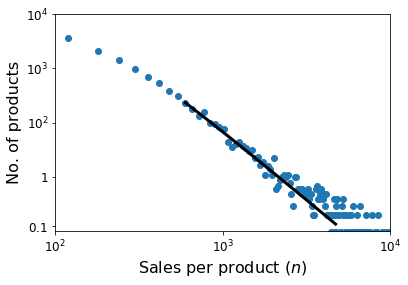

In [126]:
import matplotlib.axes as ax
fig=plt.figure(figsize=(6,4))
plt.xlim(2,4)
plt.ylim(0.01,4)
plt.xticks([2,3,4],['$10^2$','$10^3$','$10^4$'],fontsize=12)
plt.yticks([0.1,1,2,3,4],['$0.1$','$1$','$10^2$','$10^3$','$10^4$'],fontsize=12)
plt.ylabel('No. of products',fontsize=16)
plt.xlabel('Sales per product ($n$)',fontsize=16)
plt.plot(np.log10(sales_histo[1][:-1]),np.log10(sales_histo[0]),'o',np.log10(sales_histo[1][10:80]),line[10:80],'-k',lw=3)
#plt(np.log10(sales_histo[1][1:10]),linea[1:10],'-k',lw=2)
plt.savefig('histoSALESperPRODUCT.pdf')

In [130]:
print(trans_customer_day['DAY'].min())
print(trans_customer_day['DAY'].max())

1
677


# In the following, I look at the time series of some quantities such as the sales value per day, the average sales value per week, etc

In [131]:
days=[]
sales=[]
for i in range(1,2501):
    days.append(np.array(trans_customer_day[trans_customer_day['household_key']==i]['DAY']))
    sales.append(np.array(trans_customer_day[trans_customer_day['household_key']==i]['SALES_VALUE']))
    

In [132]:
a=np.ones(10)

### Sales per day for different customers

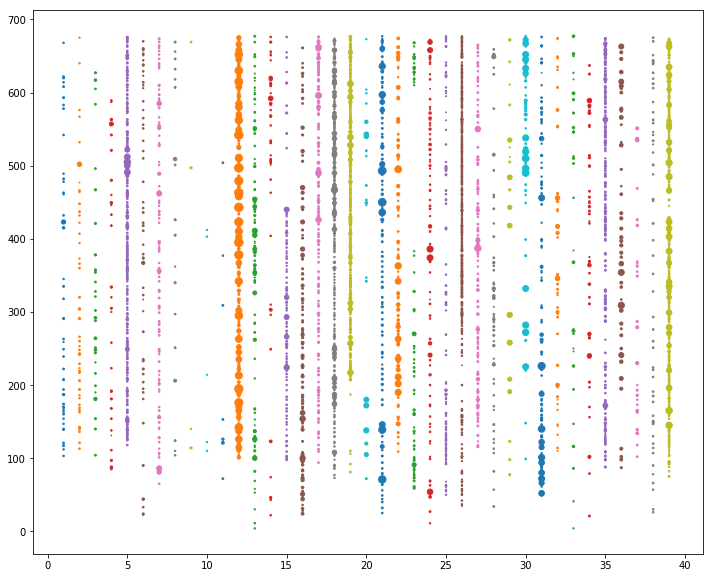

In [133]:
plt.figure(figsize=(12,10))
for i in range(1,40):
    plt.scatter(i*np.ones(len(days[i])),days[i],sales[i])

## To simplify the analysis and the visualization of the time series, we build arrays for each age group

In [140]:
trans_day=trans_short.groupby(['household_key','DAY']).mean().reset_index()[['household_key', 'DAY', 'SALES_VALUE', 'PAID_BY_CUSTOMER', 'RETAIL_DISC', 'QUANTITY','AGE']]

def days_sales(age):
    days=[]
    sales=[]
    for i in range(1,2501):
        if(trans_day[trans_day['household_key']==i]['AGE'].iloc[0]==age):
            days.append(np.array(trans_day[trans_day['household_key']==i]['DAY']))
            sales.append(np.array(trans_day[trans_day['household_key']==i]['SALES_VALUE']))
    alldays=[]
    allsales=[]
    for i in range(0,len(days)):
        c=1
        a=0
        newdays=[]
        newsales=[0]
        while (a<len(days[i])):
            while(c < days[i][a]): 
                newdays.append(c)
                newsales.append(0)
                c+=1
            newsales.pop()
            newsales.append(sales[i][a])
            a+=1
        while(c <= trans_customer_day['DAY'].max()): 
                newdays.append(c)
                newsales.append(0)
                c+=1
        newsales.pop()
        alldays.append(newdays)
        allsales.append(newsales)
    return alldays,allsales
    
    

In [141]:
days0, sales0 = days_sales(0)
days19, sales19 = days_sales(1)
days25, sales25 = days_sales(2)
days35, sales35 = days_sales(3)
days45, sales45 = days_sales(4)
days55, sales55 = days_sales(5)
days65, sales65 = days_sales(6)

## And also for each age group per week

In [149]:
trans_short.set_index(['household_key','WEEK_NO'],inplace=False)
trans_customer_week=trans_short.groupby(['household_key','WEEK_NO']).mean().reset_index()[['household_key', 'WEEK_NO','QUANTITY','SALES_VALUE','PAID_BY_CUSTOMER',
        'RETAIL_DISC','MIN_INCOME','AGE']]

def week_paid(age):
    week=[]
    paid=[]
    for i in range(1,2501):
        if(trans_customer_week[trans_customer_week['household_key']==i]['AGE'].iloc[0]==age):
            week.append(np.array(trans_customer_week[trans_customer_week['household_key']==i]['WEEK_NO']))
            paid.append(np.array(trans_customer_week[trans_customer_week['household_key']==i]['PAID_BY_CUSTOMER']))
    allweek=[]
    allpaid=[]
    for i in range(0,len(week)):
        c=1
        a=0
        newweek=[]
        newpaid=[0]
        while (a<len(week[i])):
            while(c < week[i][a]): 
                newweek.append(c)
                newpaid.append(0)
                c+=1
            newpaid.pop()
            newpaid.append(paid[i][a])
            a+=1
        while(c <= trans_week['WEEK_NO'].max()): 
                newweek.append(c)
                newpaid.append(0)
                c+=1
        newpaid.pop()
        allweek.append(newweek)
        allpaid.append(newpaid)
    return allweek,allpaid
    

In [150]:
week0, paid0 = week_paid(0)
week19, paid19 = week_paid(1)
week25, paid25 = week_paid(2)
week35, paid35 = week_paid(3)
week45, paid45 = week_paid(4)
week55, paid55 = week_paid(5)
week65, paid65 = week_paid(6)

In [193]:
len(week19)

46

288


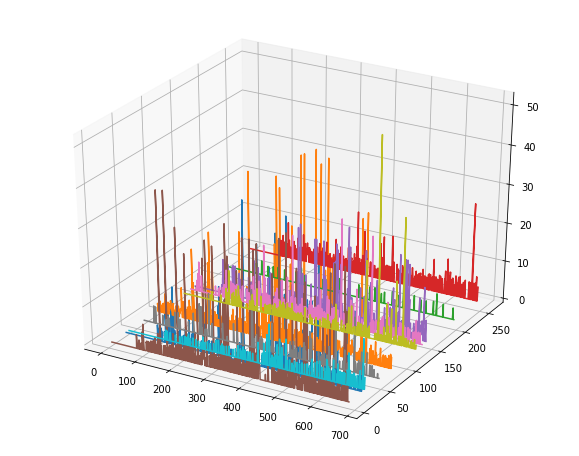

In [151]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')
v=np.random.randint(len(sales45),size=10)
print(len(sales45))
for i in v:
    ax.plot(days45[i],1*i*np.ones(len(days45[i])),sales45[i])

In [152]:
np.linspace(1,100,10,dtype=int)

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

288


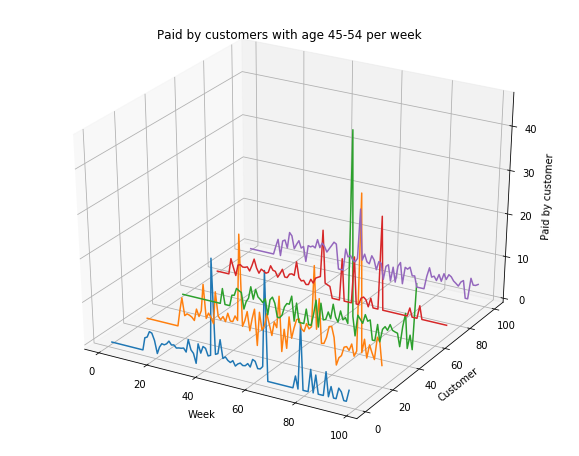

In [153]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')
ax.set_title('Paid by customers with age 45-54 per week')
ax.set_xlabel('Week')
ax.set_ylabel('Customer')
ax.set_zlabel('Paid by customer')
v=np.linspace(1,100,5,dtype=int)
print(len(paid45))
for i in v:
    plt.plot(week45[i],1*i*np.ones(len(week45[i])),paid45[i])

[0 1 2 3 4]


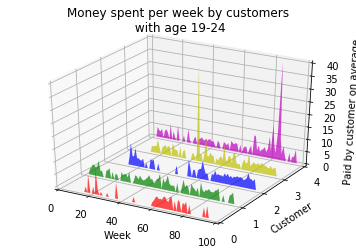

In [157]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = week19[0]
verts = []
zs=np.linspace(0,4,5,dtype=int)
print(zs)
for i in zs:
    ys = paid19[i]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors=[cc('r'), cc('g'), cc('b'),
                                         cc('y'), cc('m')])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0', '1', '2','3','4'])
ax.set_xlim3d(0, 100)
ax.set_ylim3d(0, 4)
ax.set_zlim3d(0, 40)

ax.set_xlabel('Week')
ax.set_ylabel('Customer')
ax.set_zlabel('Paid by customer on average')

plt.title('Money spent per week by customers\n with age 19-24')
plt.savefig('customers19-24_week.pdf')

194


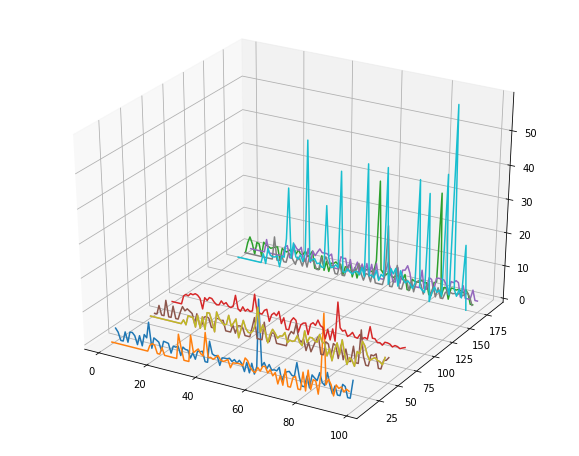

In [158]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')
v=np.random.randint(len(paid35),size=10)
print(len(paid35))
for i in v:
    ax.plot(week35[i],1*i*np.ones(len(week35[i])),paid35[i])

194


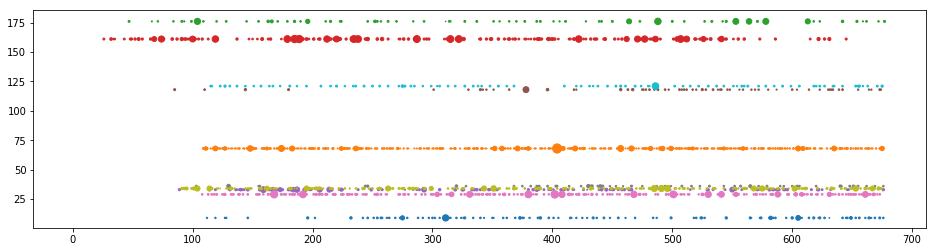

In [159]:
v=np.random.randint(len(sales35),size=10)
plt.figure(figsize=(16,4))
print(len(sales35))
for i in v:
    plt.scatter(days35[i],i*np.ones(len(days35[i])),sales35[i])

72


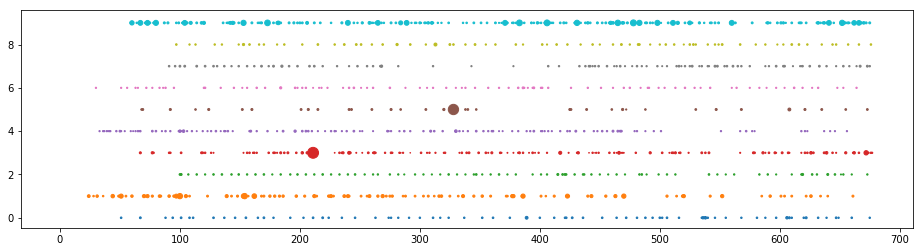

In [160]:
plt.figure(figsize=(16,4))
print(len(sales65))
for i in range(0,10):
    plt.scatter(days65[i],i*np.ones(len(days65[i])),sales65[i])

In [172]:

trans_short.set_index(['AGE','DEPARTMENT'],inplace=False)
trans_age_depto=trans_short.groupby(['AGE','DEPARTMENT']).mean().reset_index()[['AGE','DEPARTMENT','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC','MIN_INCOME']]
trans_age_depto=trans_age_depto[trans_age_depto['AGE']!=0]

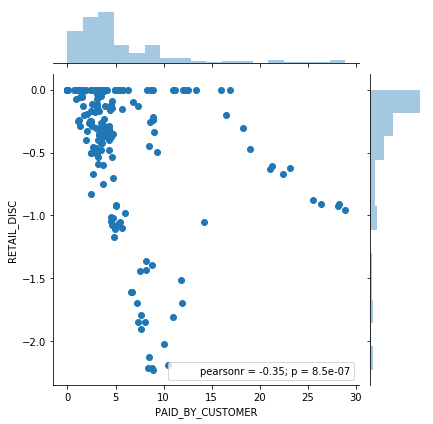

In [173]:
sns.jointplot(x=trans_age_depto['PAID_BY_CUSTOMER'],y=trans_age_depto['RETAIL_DISC'],data=trans_age_depto)

In [174]:
trans_age_depto.head(5)

,AGE,DEPARTMENT,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC,MIN_INCOME
41,19,,0.00,0.00,0.00,"43,320.92"
42,19,AUTOMOTIVE,5.82,5.82,0.00,"25,000.50"
43,19,CHEF SHOPPE,4.07,4.07,0.00,"52,105.37"
44,19,CNTRL/STORE SUP,1.00,1.00,0.00,"12,500.50"
45,19,COSMETICS,4.07,4.61,-0.54,"67,434.63"


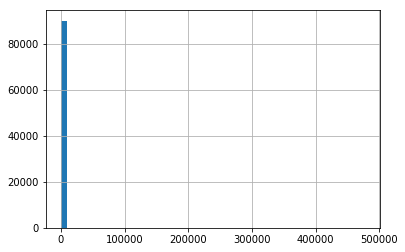

In [175]:
trans_by_prod['SALES_VALUE'].hist(bins=50)

In [177]:
trans_by_prod.head(5)

,PRODUCT_ID,household_key,DAY,WEEK_NO,STORE_ID,SALES_VALUE,PAID_BY_CUSTOMER,AGE,HH_COMP_NUMBER,RETAIL_DISC,MIN_INCOME,QUANTITY
0,25671,1911,814,118,9770,20.94,20.94,10,10,0.00,225000,6
1,26081,1675,250,36,3235,0.99,0.99,0,0,0.00,0,1
2,26093,1032,458,66,33904,1.59,1.59,0,0,0.00,0,1
3,26190,1420,238,35,3297,1.54,1.54,0,0,0.00,0,1
4,26355,486,242,35,3217,1.98,2.50,0,0,-0.52,0,2


In [178]:
prod[prod['PRODUCT_ID']==trans_by_prod[trans_by_prod['SALES_VALUE']==trans_by_prod['SALES_VALUE'].max()]['PRODUCT_ID'].iloc[0]]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [179]:
trans_by_prod[trans_by_prod['PAID_BY_CUSTOMER']==trans_by_prod['PAID_BY_CUSTOMER'].max()]['PRODUCT_ID']

56505    6534178
Name: PRODUCT_ID, dtype: int64

In [180]:
trans_age_depto[trans_age_depto['PAID_BY_CUSTOMER']==trans_age_depto['PAID_BY_CUSTOMER'].max()]

,AGE,DEPARTMENT,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC,MIN_INCOME
187,55,KIOSK-GAS,27.95,28.91,-0.95,"76,756.96"


Delete the 10 most sold products to see the tail

In [1118]:
#for i in range(10): trans_age_depto.drop(trans_age_depto[trans_age_depto['PAID_BY_CUSTOMER']==trans_age_depto['PAID_BY_CUSTOMER'].max()].index,axis=0,inplace=True)

In [181]:
df=trans_age_depto.sort_values(by='PAID_BY_CUSTOMER',ascending=False)[['AGE','DEPARTMENT','PAID_BY_CUSTOMER']]

In [182]:
trans_age_depto.pivot('AGE','DEPARTMENT','PAID_BY_CUSTOMER').columns

Index([' ', 'AUTOMOTIVE', 'CHEF SHOPPE', 'CNTRL/STORE SUP', 'COSMETICS',
       'COUP/STR & MFG', 'DAIRY DELI', 'DELI', 'DELI/SNACK BAR', 'DRUG GM',
       'FLORAL', 'FROZEN GROCERY', 'GARDEN CENTER', 'GM MERCH EXP',
       'GRO BAKERY', 'GROCERY', 'HBC', 'HOUSEWARES', 'KIOSK-GAS', 'MEAT',
       'MEAT-PCKGD', 'MEAT-WHSE', 'MISC SALES TRAN', 'MISC. TRANS.',
       'NUTRITION', 'PASTRY', 'PHARMACY SUPPLY', 'PHOTO', 'POSTAL CENTER',
       'PROD-WHS SALES', 'PRODUCE', 'RESTAURANT', 'RX', 'SALAD BAR', 'SEAFOOD',
       'SEAFOOD-PCKGD', 'SPIRITS', 'TOYS', 'TRAVEL & LEISUR', 'VIDEO RENTAL'],
      dtype='object', name='DEPARTMENT')

# Heat map of the average sales value spent by customers in an age group for each department. These data were used in the multi-class classifier

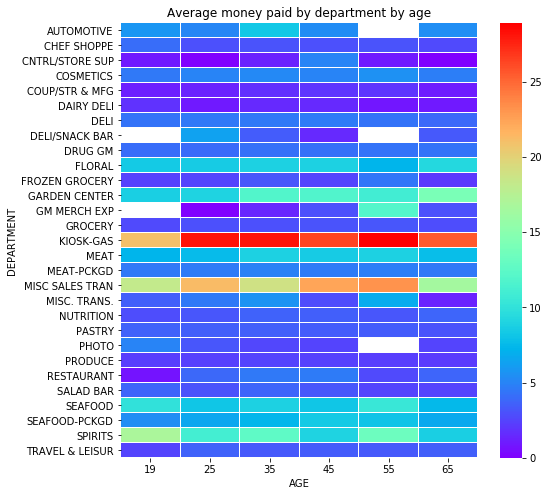

In [183]:
fig=plt.figure(figsize=(8,8))
plt.title('Average money paid by department by age')
transforheat=trans_age_depto.pivot('DEPARTMENT','AGE','PAID_BY_CUSTOMER').drop([' ','RX','GRO BAKERY','HBC','HOUSEWARES','MEAT-WHSE','PHARMACY SUPPLY','POSTAL CENTER', 'PROD-WHS SALES','TOYS', 'VIDEO RENTAL'],axis=0)
ax=sns.heatmap(transforheat,annot=False,cmap="rainbow", linewidths=.1,)
plt.savefig('heatAGE_DEPTOmean.pdf',pad_inches=5)

In [184]:
trans_short.set_index(['HH_COMP_NUMBER','DEPARTMENT'],inplace=False)
trans_hh_depto=trans_short.groupby(['HH_COMP_NUMBER','DEPARTMENT']).sum().reset_index()[['HH_COMP_NUMBER','DEPARTMENT','SALES_VALUE']]

In [185]:
hh_code={'Single Female':1, 'Single Male':-1, '1 Adult Kids':2, '2 Adults No Kids':-2, '2 Adults Kids':3, 'Unknown':0,
        }

# Heat map for money spent in each department according to the household composition

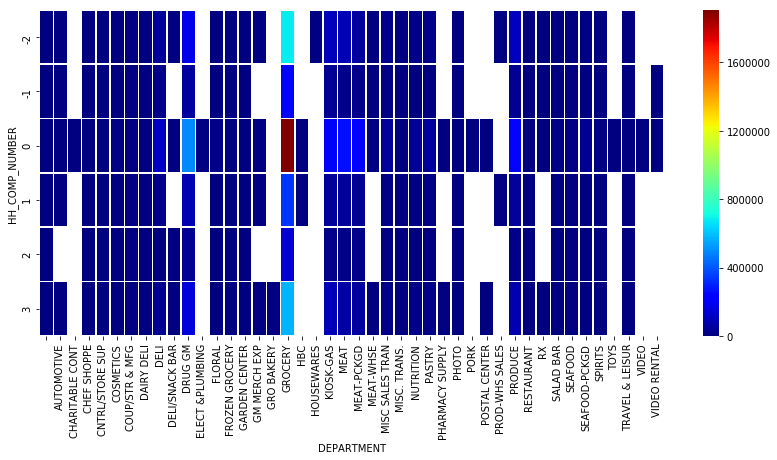

In [186]:
fig=plt.figure(figsize=(14,6))
transhforheat=trans_hh_depto.pivot('HH_COMP_NUMBER','DEPARTMENT','SALES_VALUE')
ax=sns.heatmap(transhforheat,annot=False,cmap="jet", linewidths=.5)

In [187]:
trans_week=trans_short.groupby('WEEK_NO').mean().reset_index()[['WEEK_NO','SALES_VALUE','PAID_BY_CUSTOMER','RETAIL_DISC']]

In [188]:
trans_week.head(5)

,WEEK_NO,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1,2.77,3.32,-0.55
1,2,2.94,3.53,-0.58
2,3,2.81,3.34,-0.53
3,4,2.97,3.51,-0.54
4,5,2.81,3.37,-0.55


Text(0,0.5,'Average sales value')

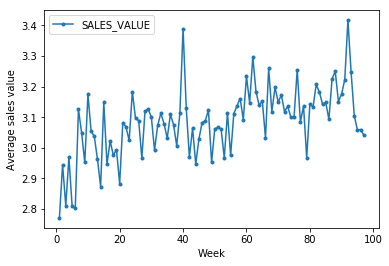

In [189]:
fig=plt.figure(figsize=(10,6))
trans_week.plot(x='WEEK_NO',y='SALES_VALUE',style='.-')
plt.xlabel('Week')
plt.ylabel('Average sales value')

In [190]:
trans_week.head()

,WEEK_NO,SALES_VALUE,PAID_BY_CUSTOMER,RETAIL_DISC
0,1,2.77,3.32,-0.55
1,2,2.94,3.53,-0.58
2,3,2.81,3.34,-0.53
3,4,2.97,3.51,-0.54
4,5,2.81,3.37,-0.55


In [191]:
sales_week=trans_week[['SALES_VALUE']][0:].reset_index(level=0)

In [192]:
sales_week.drop('index',axis=1,inplace=True)

In [193]:
sales_week['WEEK']=sales_week.index +1
data=sales_week[['WEEK','SALES_VALUE']]

In [194]:
data.set_index('WEEK',inplace=True)

In [195]:
data.head()

,SALES_VALUE
WEEK,
1,2.77
2,2.94
3,2.81
4,2.97
5,2.81


Text(0,0.5,'sales')

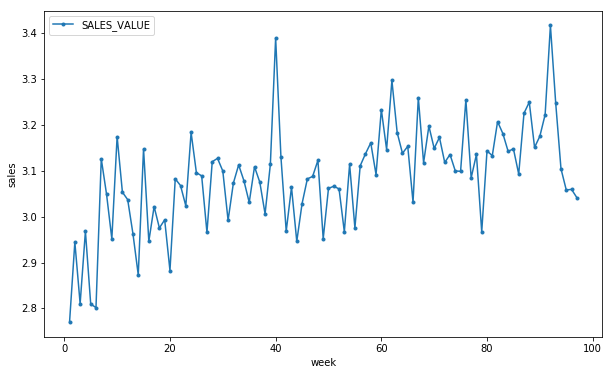

In [196]:
fig=plt.figure(figsize=(10,6))
sales_week.plot(x='WEEK',y='SALES_VALUE',figsize=(10,6),style='.-')
plt.xlabel('week')
plt.ylabel('sales')

# Now, I aim to build an ARIMA model for the average sales per week in order to predict the sales for the future weeks to come

In [197]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams


def check_stationarity(timeseries):
    
    # Determine rolling statistics (moving averages and variance)
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.savefig('rollmean.pdf')
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [198]:
# Converting to a series object for convenience
ts = data['SALES_VALUE'] 
ts.head()

WEEK
1   2.77
2   2.94
3   2.81
4   2.97
5   2.81
Name: SALES_VALUE, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -4.21
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   95.00
Critical Value (1%)           -3.50
Critical Value (5%)           -2.89
Critical Value (10%)          -2.58
dtype: float64


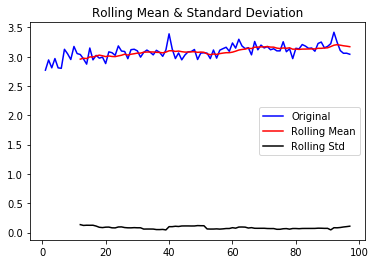

In [199]:
check_stationarity(ts)

In [200]:
#If the series is not stationary
#ts_log = np.log(ts)
#plt.plot(ts_log)

WEEK
1     nan
2     nan
3     nan
4     nan
5     nan
6     nan
7     nan
8    0.14
9    0.02
10   0.21
11   0.06
12   0.04
Name: SALES_VALUE, dtype: float64

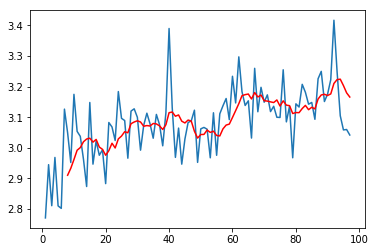

In [201]:
moving_avg = pd.rolling_mean(ts,8)
plt.plot(ts)
plt.plot(moving_avg, color='red')

# Subtract rolling average
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.head(12)

Results of Dickey-Fuller Test:
Test Statistic                -8.06
p-value                        0.00
#Lags Used                     0.00
Number of Observations Used   89.00
Critical Value (1%)           -3.51
Critical Value (5%)           -2.89
Critical Value (10%)          -2.58
dtype: float64


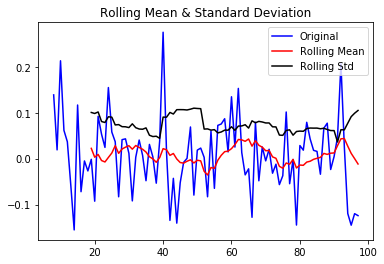

In [202]:
ts_moving_avg_diff.dropna(inplace=True)
check_stationarity(ts_moving_avg_diff)


# For forecasting:

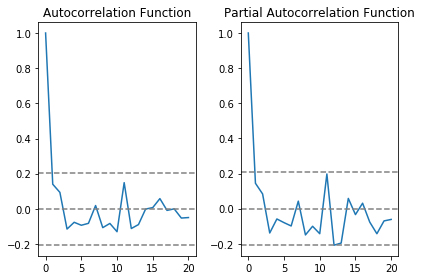

In [203]:
# ACF (autocorrelation function) and PACF (partial autocorrelation function) plots:
lag_acf = acf(ts_moving_avg_diff, nlags=20)
lag_pacf = pacf(ts_moving_avg_diff, nlags=20, method='ols')

# Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

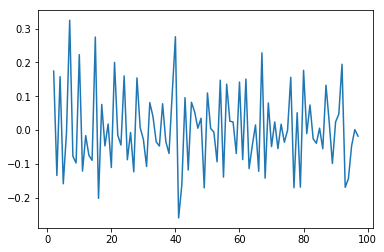

In [204]:
#Removing trend and seasonality by differencing
ts_diff = ts - ts.shift()
plt.plot(ts_diff)

In [207]:
np.array(ts)

array([ 2.77041999,  2.94458503,  2.81036852,  2.96820785,  2.80968471,
        2.80169739,  3.12627728,  3.04888473,  2.9517402 ,  3.17465702,
        3.05347181,  3.03719164,  2.96248846,  2.87311278,  3.14799873,
        2.9463126 ,  3.02208357,  2.97541047,  2.99318643,  2.88259574,
        3.08253415,  3.06791579,  3.02366444,  3.18376642,  3.09612214,
        3.0890305 ,  2.96574673,  3.11990945,  3.127265  ,  3.09963871,
        2.99205703,  3.07326056,  3.11295178,  3.07828478,  3.03115133,
        3.10892147,  3.07533897,  3.00625715,  3.11411274,  3.3900226 ,
        3.13042106,  2.9684711 ,  3.06423352,  2.94627593,  3.02847972,
        3.0824009 ,  3.087872  ,  3.12282336,  2.95209179,  3.06171921,
        3.06645382,  3.06062701,  2.96702014,  3.11434659,  2.97527442,
        3.11098054,  3.13717329,  3.16103373,  3.09186693,  3.23371397,
        3.14653618,  3.29723313,  3.18339713,  3.13826295,  3.15343929,
        3.03161867,  3.25976596,  3.11768609,  3.19764312,  3.14

Text(0.5,1,'RSS: 0.9496')

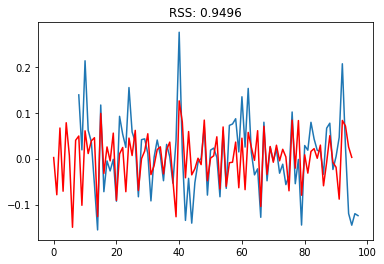

In [208]:
# Combined model
model = ARIMA(ts.to_frame().dropna().as_matrix(), order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_moving_avg_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[6:]-ts_moving_avg_diff)**2))

In [209]:
results_ARIMA.arparams, results_ARIMA.maparams

(array([-0.47162383]), array([], dtype=float64))

To scale back to original values

In [210]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

0    0.00
1   -0.08
2    0.07
3   -0.07
4    0.08
dtype: float64


Text(0.5,1,'RMSE: nan')

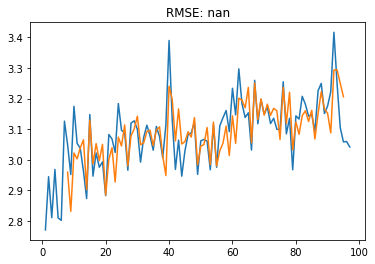

In [211]:
predictions_ARIMA = predictions_ARIMA_diff+moving_avg
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA.dropna()-ts)**2)/len(ts)))

In [212]:
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
 
def predict(coef, history):
	yhat = 0.0
	for i in range(1, len(coef)+1):
		yhat += coef[i-1] * history[-i]
	return yhat
 
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)
 

X = np.array(ts)
size = len(X) - 10
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	ar_coef, ma_coef = results_ARIMA.arparams, results_ARIMA.maparams
	resid = results_ARIMA.resid
	diff = difference(history)
	yhat = history[-1] + predict(ar_coef, diff) #+ predict(ma_coef, resid)
	predictions.append(yhat)
	obs=test[t]
	history.append(obs)
	print('>predicted=%.3f, expected=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

>predicted=3.163, expected=3.250
>predicted=3.238, expected=3.151
>predicted=3.198, expected=3.175
>predicted=3.164, expected=3.223
>predicted=3.200, expected=3.417
>predicted=3.325, expected=3.248
>predicted=3.328, expected=3.105
>predicted=3.172, expected=3.058
>predicted=3.080, expected=3.060
>predicted=3.059, expected=3.042
Test RMSE: 0.116


In [222]:
future=pd.DataFrame(results_ARIMA.predict(start = 95, end = 100, dynamic= False)+np.array(moving_avg)[-1],index=list(range(95,101)))
ts_future=pd.concat([predictions_ARIMA,future]).dropna()
print(ts_future[-15:])

       0
87  3.15
88  3.22
89  3.17
90  3.15
91  3.09
92  3.29
93  3.29
94  3.25
95  3.21
95  3.19
96  3.17
97  3.18
98  3.16
99  3.17
100 3.17


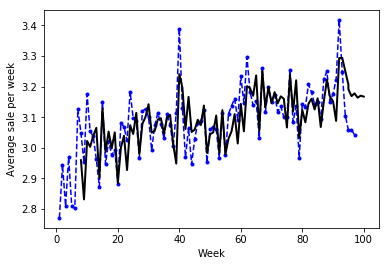

In [223]:
predictions_ARIMA = predictions_ARIMA_diff+moving_avg
plt.plot(ts,'.--b')
plt.ylabel('Average sale per week')
plt.xlabel('Week')
plt.plot(ts_future,'-k',lw=2)
plt.savefig('arima.pdf')

# It is still pending to apply an algorithm for outlier detection to detect anomalous customers

From time series of sales per week for a particular group age, can we detect customers with anomalous behaviour?


Isolation Forest:

In [ ]:
#Données brutes normées avec StandardScaler
isforest = IsolationForest(n_estimators=20)
isforest.fit(signals_std)
detection_b = isforest.predict(signals_std)
print("Anomalous time series are ", [i+1 for i,x in enumerate(detection_b) if x == -1])

#Amplitudes des signaux  (FFT)
isforest = IsolationForest(n_estimators=40)
isforest.fit(amplitude)
detection_c = isforest.predict(amplitude)
print("Anomalous time series are ", [i+1 for i,x in enumerate(detection_c) if x == -1])

In [ ]:
#Principal components analysis des amplitudes
outliers=[]
for i in range(0,20):
    isforest = IsolationForest(n_estimators=20)
    isforest.fit(pca_amplitude)
    detection = isforest.predict(pca_amplitude)
    for l in [i+1 for i,x in enumerate(detection) if x == -1]: 
        if l not in outliers: outliers.append(l)

In [ ]:
print("Anomalous time series are ", sorted(outliers))